# Allosteric network analysis: -log(weight)
## 0. Import packages and set directories

In [1]:
# AlloViz
import AlloViz

# Other packages
import pandas as pd
import networkx as nx
import numpy as np
from itertools import chain
import nglview as nv

In [4]:
# Directory that contains the trajectories
traj_dir = ""

## 1. System setup

In [5]:
GPCR = AlloViz.Protein(pdb = "", # PDB file
                    psf = "", # PSF file
                    trajs = [], # All the replicas
                    name = "", # Name string to be used, e.g., for the title of the colorbar 
                               # shown when representing a network with nglviewer
                    path = "data")

# Calculate network based on GetContacts residue-residue interaction frequencies
GPCR.calculate("GetContacts")

# Filters: minimum interaction frequecy of 1%, not sequence neighbors (interactions between amino acid i
# and i+1 removed) and GetContacts interaction frequency
# For normal AlloViz, just specify the lower threshold (e.g. GetContacts_threshold = 0.05)

GPCR.filter(filterings=[["GetContacts_edges", "No_Sequence_Neighbors"]], 
            Sequence_Neighbor_distance = 1, GetContacts_threshold = [0.05, 1.00]) 

# Analyze: betweenness
GPCR.analyze(elements=["edges", "nodes"], metrics="btw")

FileNotFoundError: Some of the files could not be found: {'': False}

## 2. Suboptimal path search
Define one source (like A) and one or more sinks (like F).

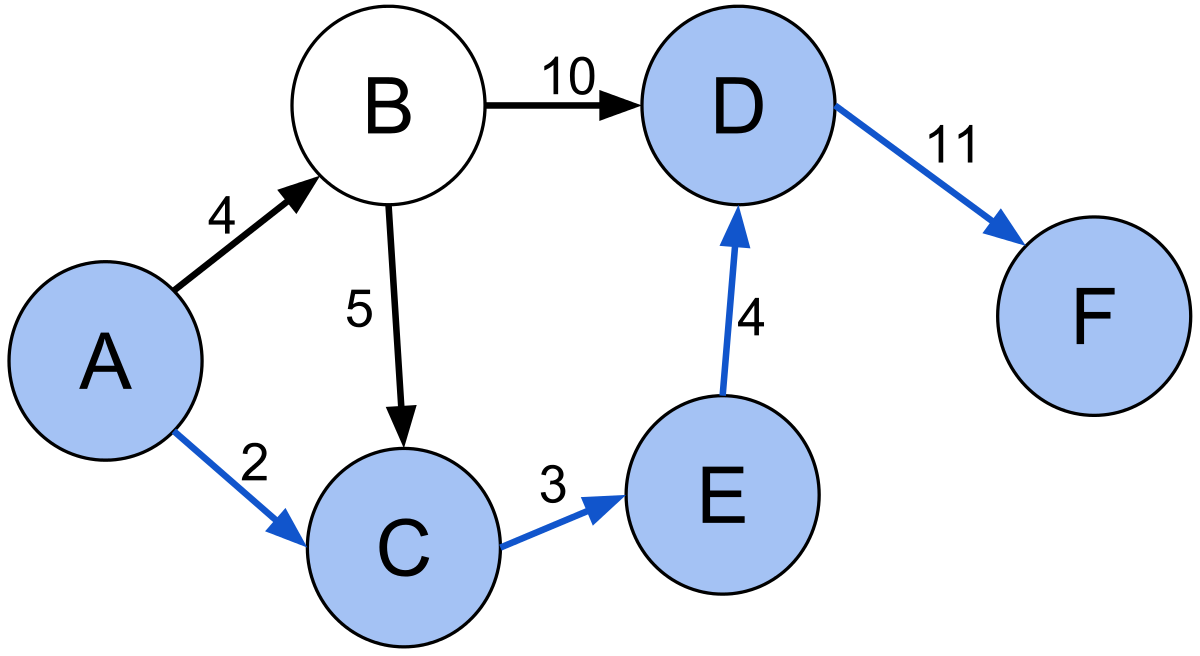

In [ ]:
sinks = [] # Select sink(s)

# Make a dictionaty to later turn it into a data frame
subopt_paths_dict = {"sink": [], 
                      "replica": [], 
                      "path": [],
                      "nresidues": [], # Number of residues (nodes) of the path
                      "w_path_length": [], # Weighted path length
                      "u_path_length": []} # Unweighted path length (number of edges)

for sink in sinks:
    for graph in GPCR.GetContacts.GetContacts_edges_No_Sequence_Neighbors.graphs: # Iterate to get each 
                                                                                  # replica's graph

        i = 0 # Counter to get just X shortest paths
        
        if graph != "weight": # Avoid using the "average" network
            # The functions that calcualtes all simple paths returns a generator object
            network = GPCR.GetContacts.GetContacts_edges_No_Sequence_Neighbors.graphs[graph]
            generator = nx.shortest_simple_paths(G = network,
                                                 source = "", # Select source
                                                 target = sink,
                                                 weight = "weight")

            for path in generator: # Each item for the generator is a path going from the source to the sink                        
                if i < X: # Get just X shortest paths

                    # Save data to dictionary
                    subopt_paths_dict["sink"].append(sink)
                    subopt_paths_dict["replica"].append(graph)
                    subopt_paths_dict["path"].append(path)
                    subopt_paths_dict["nresidues"].append(len(path))
                    subopt_paths_dict["u_path_length"].append(len(path) - 1) 


                    # Calculate weighted path length and save data to dictionary
                    w_path_length = nx.path_weight(G = network, 
                                                   path = path, 
                                                   weight = "weight") 

                    subopt_paths_dict["w_path_length"].append(w_path_length)
                    i = i + 1 # Increment counter

                else:
                    break # Go back to select another graph


subopt_paths_df = pd.DataFrame(subopt_paths_dict)
subopt_paths_df

## 4. Represent pathways in 3D

In [ ]:
# Get color gradient for network edges
def get_color_gradient(value, max_norm, max_col):
    """
    * The value parameter represents the value that needs to be plotted on the color gradient.
    * The max_norm parameter is the maximum value of value that the color gradient will be based on. The value of value will be normalized between 0 and 1 based on the max_norm.
    * The max_col parameter is the maximum color value for the end color. The start color is always light gray with RGB values of [0.9, 0.9, 0.9].
    """
    
    # Define the endpoints of the gradient
    start_color = [0.9, 0.9, 0.9]  # light_gray
    end_color = max_col
    
    # Interpolate between the endpoints based on the value
    t = value / max_norm  # normalize to [0, 1]
    color = [start_color[i] + t * (end_color[i] - start_color[i]) for i in range(3)]
    
    return color

### 4.1. Select suboptimal paths

In [ ]:
# Extract suboptimal paths
subopt_paths = subopt_paths_df.path

# Define the states, which are the nodes of the network (the residues), to calculate the transitions
states = list(set(list(chain(*subopt_paths))))

# Create an empty pandas data frame to count the transitions
transition_df = pd.DataFrame(data = 0, index = states, columns = states) # From row to column

# Fill the transition dataframe
for path in subopt_paths:
    for i in range(len(path) - 1):
        current_state = path[i]
        next_state = path[i + 1]
        transition_df.loc[current_state, next_state] += 1
        
# Find maximum transitions to normalize edge size and color
max_weight = transition_df.max().max()

# Relativize transition matrix: in what percentage of all the calculated paths is a specific contact found?
# Maybe you want to save this
transition_df_rel = transition_df/len(subopt_paths)

In [ ]:
# Load your GPCR structure
ngl_struct = nv.show_mdanalysis(GPCR.protein, default=False)
ngl_struct.add_cartoon("protein", color = "white")
ngl_struct.center("protein")
ngl_struct.camera = 'orthographic' 
ngl_struct

In [ ]:
# Add edges
for res1 in transition_df.index:
    for res2 in transition_df.columns:
        
        weight = transition_df.loc[res1, res2]
        if weight > 0:
            edge_color = get_color_gradient(weight, max_weight, [96 / 255, 227 / 255, 124 / 255])
            GPCR.GetContacts.GetContacts_edges_No_Sequence_Neighbors.edges._add_element(ngl_struct, 
                                                                                        GPCR.protein,
                                                                                        [res1, res2],
                                                                                        edge_color,
                                                                                        weight / max_weight)